In [185]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [186]:
path='dataset\\hmnist_28_28_RGB.csv'
df=pd.read_csv(path)
df.tail()

classes = {
    0: ("actinic keratoses and intraepithelial carcinomae(Cancer)"),
    1: ("basal cell carcinoma(Cancer)"),
    2: ("benign keratosis-like lesions(Non-Cancerous)"),
    3: ("dermatofibroma(Non-Cancerous)"),
    4: ("melanocytic nevi(Non-Cancerous)"),
    5: ("pyogenic granulomas and hemorrhage(Can lead to cancer)"),
    6: ("melanoma(Cancer)"),
}

In [187]:
# Split dataset into train and test set
fractions=np.array([0.8,0.2])
df=df.sample(random_state=1, frac=1)
train_set, test_set = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))
print(len(test_set))

C:\Users\zengo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


2003


In [188]:
# Split test set into X and Y
y_test = test_set['label']
x_test = test_set.drop(columns=['label'])
x_test=np.array(x_test).reshape(-1,28,28,3)

In [189]:
# Load the pre-trained model
model = keras.models.load_model('best_model.h5')
model.trainable = True


In [190]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 14, 14, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)         

In [191]:
# Accuracy of pre-trained model on test set
score = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
print('Test loss:', score[0])
print('Test accuracy (%):', 100*score[1])

Test loss: 0.22749203443527222
Test accuracy (%): 94.85771059989929


## Attack

In [217]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_compromised_image(image, epsilon):
  image = tf.convert_to_tensor(image.reshape((1, 28, 28, 3)), dtype=tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    label = tf.argmax(prediction, axis=1)
    loss = loss_object(label, prediction)

  gradient = tape.gradient(loss, image)
  perturbations = tf.sign(gradient)

  adversarial_image = image + epsilon*perturbations
  return adversarial_image


## Test Out Attack

1/1 [==============================] - 0s 38ms/step


Creating Compromised Images:   2%|▏         | 47/2003 [00:53<36:59,  1.13s/it]

melanocytic nevi(Non-Cancerous)


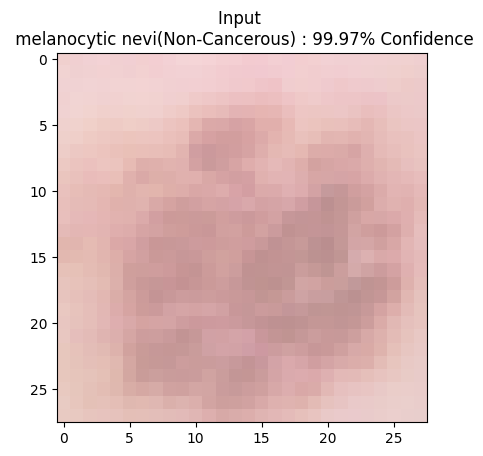

1/1 [==============================] - 0s 28ms/step
melanocytic nevi(Non-Cancerous)


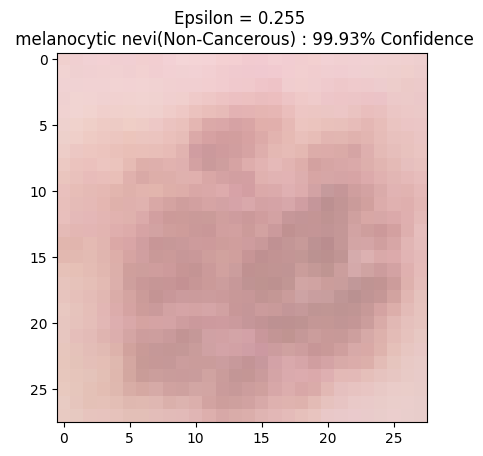

1/1 [==============================] - 0s 38ms/step
basal cell carcinoma(Cancer)


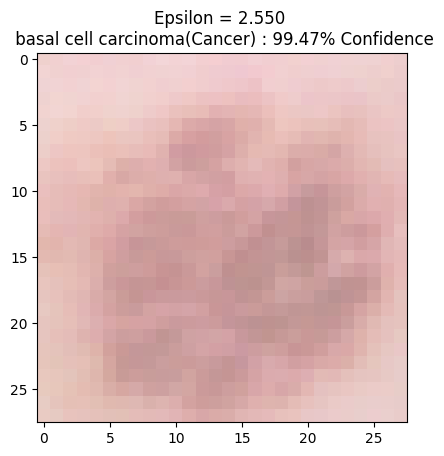

1/1 [==============================] - 0s 29ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


basal cell carcinoma(Cancer)


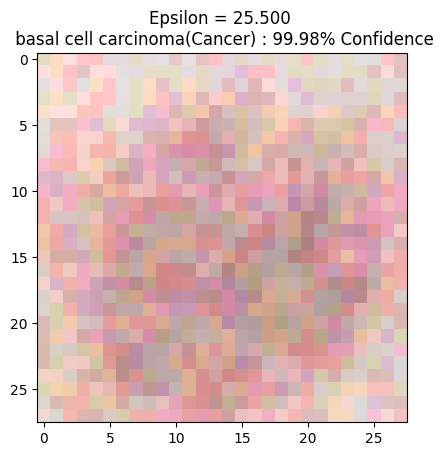

1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


basal cell carcinoma(Cancer)


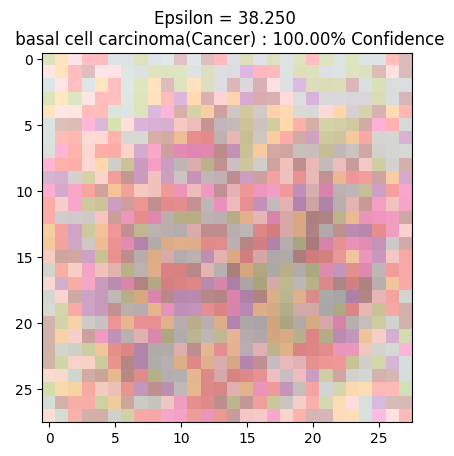

In [198]:
def display_images(new_image, description):
  #  Display the given image along with its predicted label and confidence.
  pred = model.predict(new_image)
  label = np.argmax(pred, axis=1)[0]
  label = classes[label]
  confidence = np.max(pred, axis=1)[0]
  plt.figure()
  plt.imshow(new_image[0]*0.5/255+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
  plt.show()

epsilons = np.array([0, 0.001, 0.01, 0.1, 0.15])*255
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = create_compromised_image(x_test[0], eps)
  display_images(adv_x, descriptions[i])

## Test Attck on multiple images and plot the accuracy for different epsilons











Creating Compromised Images: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


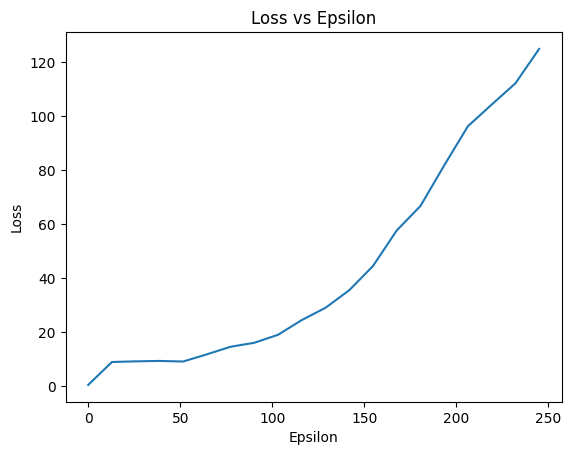

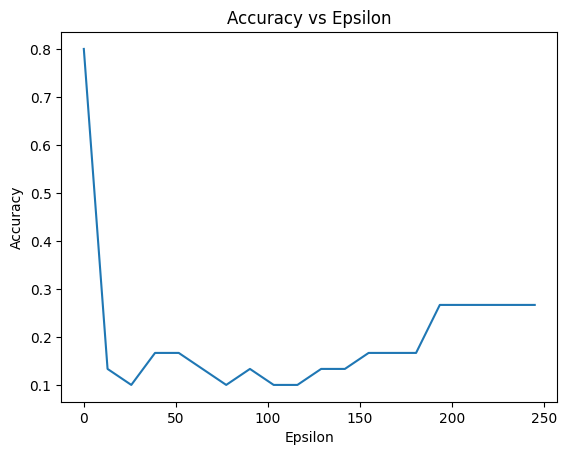

In [226]:
epsilon = np.linspace(0, 245, 20)
# x_test_compromised = np.array([create_comprimised_image(img, eps)[0] for img in tqdm(x_test[:], desc="Creating Compromised Images")])


test_loss = []
test_acc = []
for eps in epsilon:
    x_test_compromised = []
    for img in x_test[:30]:
        adv_x = create_compromised_image(img, eps)[0]
        x_test_compromised.append(adv_x)

    x_test_compromised = np.array(x_test_compromised)
    score = model.evaluate(x_test_compromised, y_test[:30], verbose=0, batch_size=1)
    test_loss.append(score[0])
    test_acc.append(score[1])

plt.figure()
plt.plot(epsilon, test_loss)
plt.title('Loss vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(epsilon, test_acc)
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()